# Import

In [1]:
import glob
import os
import sys
import random
import time
import numpy as np
import math
import datetime
from collections import deque
from keras.models import Sequential
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.models import model_from_json
import pandas as pd
from plotnine import *
from jupyterplot import ProgressPlot

import tensorflow as tf
import keras.backend.tensorflow_backend as backend
from threading import Thread
from tqdm import tqdm_notebook as tqdm

#check os
try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla
print('IMPORT DONE')

#recommend to use conda install in the library of Tensorflow and keras

Using TensorFlow backend.


IMPORT DONE


# Car Environment [Action/Reward here]

In [2]:
class CarEnv:

    def __init__(self):
        # connect to carla
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(5.0)
        self.world = self.client.get_world()
        
        # change the view of camera to the place we want to train
        spectator = self.world.get_spectator()
        spectator.set_transform(carla.Transform(carla.Location(-142,110,2)))
        
        # destroy all vehices and sensors to prepare the environment
        for x in list(self.world.get_actors()):
            if 'vehicle' in x.type_id or 'sensor' in x.type_id:
                x.destroy()
        
        # spawn a vehicle
        blueprint_library = self.world.get_blueprint_library()
        self.Isetta = blueprint_library.filter('Isetta')[0]
        transform = carla.Transform(carla.Location(-127,121,3),carla.Rotation(0,-90,0))
        self.vehicle = self.world.spawn_actor(self.Isetta, transform)
        
        # set vehicle parameter
        self.front_left_wheel  = carla.WheelPhysicsControl(max_steer_angle=44.0, radius=25.39)
        self.front_right_wheel = carla.WheelPhysicsControl(max_steer_angle=48.0, radius=25.39)
        self.rear_left_wheel   = carla.WheelPhysicsControl(max_steer_angle=0.0,  radius=25.39)
        self.rear_right_wheel  = carla.WheelPhysicsControl(max_steer_angle=0.0,  radius=25.39)
        self.wheels = [self.front_left_wheel, self.front_right_wheel, self.rear_left_wheel, self.rear_right_wheel]
        physics_control = self.vehicle.get_physics_control()
        physics_control.wheels = self.wheels
        physics_control.mass = 490.8
        physics_control.gear_switch_time = 0.0
        self.vehicle.apply_physics_control(physics_control)
        
        # set the lidar parameter and attach it to the vehicle
        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '300000')
        self.lidar_sensor.set_attribute('channels', '16')
        self.lidar_sensor.set_attribute('range', '100')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '20')
        transform = carla.Transform(carla.Location(x=0, z=1.875))
        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)
        
        # set the colsensor parameter and attach it to the vehicle
        transform2 = carla.Transform(carla.Location(x=1.1975, z=0.7)) #หน้ารถ HA:MO ยาว 1.1975 เมตร
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        
        # get data from the sensors
        self.sensor.listen(lambda data: self.process_lidar(data))
        self.colsensor.listen(lambda event: self.collision_data(event))
        
        # sleep to get things start
        time.sleep(4)
        
        # define collision history as a list
        self.collision_hist = []
        
    def Black_screen(self):
        # if you want to train in no-rendering mode of CARLA 
        settings = self.world.get_settings()
        settings.no_rendering_mode = True
        self.world.apply_settings(settings)
    
    def get_fps():
        # get the fps at the moment of CARLA 
        world_snapshot = self.world.get_snapshot()
        fps = 1/world_snapshot.timestamp.delta_seconds
        return fps
          
    def reset(self): 
        # reset environment
        # after the crash, the car may bounce off the ground. Teleport it back to the floor and stop the car.
        self.vehicle.set_transform(carla.Transform(carla.Location(-127, 125, 0.5),carla.Rotation(0, -90, 0)))
        self.vehicle.set_angular_velocity(carla.Vector3D(x=0.0, y=0.0, z=0.0))
        self.vehicle.set_velocity(carla.Vector3D(x=0.0, y=0.0, z=0.0))
        
        # turn the steered wheel back
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, steer=0.0, brake=0.0))
        time.sleep(0.3)
        
        # teleport the vehicle to the start point and set the initial velocity 
        self.vehicle.set_transform(carla.Transform(carla.Location(-127,125,0.5),carla.Rotation(0,-90,0)))
        self.vehicle.set_velocity(carla.Vector3D(x=0.0, y=-10, z=0.0))
        time.sleep(0.2) 
        
        self.collision_hist = []
        self.episode_start = time.time()
        
        xx = self.distance_to_obstacle
        vv = -self.vehicle.get_velocity().y
        aa = 0
        sign = 0
        state_=np.array([xx, vv, aa, sign])
       
        return state_

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        # get distance to the obstacle(wall)
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        points_filter = lidar_line(points, 90, 1)
        if len(points_filter) == 0:
            pass
        else:
            # minus length of the front car hood
            self.distance_to_obstacle = min(points_filter[:,1])-1.1898 

    def step(self, action):
        # action and reward
        global sleepy  
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0))
            time.sleep(sleepy) # @FPS = 10, should use sleepy = 0.3
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0, steer = 0.0))
            time.sleep(sleepy) # @FPS = 10, should use sleepy = 0.3
        elif action == 2:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=1.0, steer = 0.0))
            time.sleep(sleepy) # @FPS = 10, should use sleepy = 0.3    
  
        xx = self.distance_to_obstacle
        vv = -self.vehicle.get_velocity().y
        aa = -self.vehicle.get_acceleration().y 
        if xx >= 8:
            sign = 0 # normal signal
        else:
            sign =1 # brake signal
 
        state_=np.array([xx,vv,aa,sign])
 
        kmh = abs(int(3.6 * vv))
    
        # set velocity and collision end terminal
        if kmh == 0 and len(self.collision_hist) == 0 :
            done = True
            if -1<= xx <8:
                reward = 1/36*((-xx**2) + 4*xx+32)
            elif  8<= xx :
                reward = 0
        elif len(self.collision_hist) != 0 :
            done = True
            reward = -1
        else:
            done = False
            reward = 0  
        
        #set time-up end terminal
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        return state_, reward, done, None

# Optional Function

In [3]:
# function to open CARLA Simulator. Please change the path to yours before use.
def open_carla(require):
    try:
        if require == 'fast':
            os.popen('D:\\Desktop\\CARLA_0.9.8\\WindowsNoEditor\\CarlaUE4.exe -benchmark  -fps=10 -quality-level=Low -ResX=360 -ResY=240')
        elif type(require) == int:
            os.popen('D:\\Desktop\\carla_0.9.8_D\\WindowsNoEditor\\CarlaUE4.exe -benchmark  -fps=' + str(require)+' -quality-level=Low -ResX=360 -ResY=240')
        else:
            os.popen('D:\\Desktop\\carla_0.9.8_D\\WindowsNoEditor\\CarlaUE4.exe -benchmark  -fps=90 -quality-level=Low -ResX=360 -ResY=240')
    except Exception as err:
        print(err)
    print('opening Carla')

# function to close CARLA Simulator.
def close_carla():
    try:
        os.system('TASKKILL /F /IM CarlaUE4.exe')
    except Exception as err:
        print(err)
    time.sleep(0.5)

# function to check whether the CARLA Simulator is running.
def carla_is_running():
    import psutil    
    if "CarlaUE4.exe" in (p.name() for p in psutil.process_iter()):
        return True

# function to destroy all the vehicles and sensors
def xxx():
    for x in list(env.world.get_actors()):
        if 'vehicle' in x.type_id or 'sensor' in x.type_id:
            x.destroy()

# function to screen the 3D lidar point cloud to a width straight line in the quadrant degree direction from the car 
# unit is metre
def lidar_line(points, degree, width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], 
                                       np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

# function to save the data and model every 5000 episodes, please change the path before use.
def save_every_n_episode(num_of_episode):
        # data prep.
        n=cum=avg=0   
        avg_loss=[]
        for i in Loss[1:]:
            n+=1
            cum+=i
            avg=cum/n
            avg_loss.append(avg)

        df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,
                         'avg_reward':avg_reward,'Step':Step,'Loss':Loss[1:],
                         'avg_loss':avg_loss,
                         'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100,
                         'Epsilon':Epsilon, 'Dist_stop':Dist_stop,
                         'Max_accel':Max_accel, 'Avg_accel':Avg_accel})
        if LOAD == True:
            df=pd.concat([df_load,df],ignore_index=True)   

        ###save data
        name='full_deep_brake_cont_reward_limit_action@' + str(num_of_episode) ##INSERT FILE NAME
        n = datetime.datetime.now()
        n = n.strftime('_%m%d%y_%H%M')

        ##real
        file_path="DATA\\"
        df.to_csv(file_path+'{}.csv'.format(name))
        agent.save_model(file_path+name)

        ##backup
        name=name+n
        file_path_backup="DATA\\backup\\"
        df.to_csv(file_path_backup+'{}.csv'.format(name))
        agent.save_model(file_path_backup+name)            

# DQN Algorithm

In [4]:
class DQNAgent:
    
    def __init__(self,state_size,action_size):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     
        

    def create_model(self):
        
        model = Sequential()
        model.add(Dense(4, input_dim=self.state_size, activation='relu'))
        model.add(Dense(4, input_dim=4, activation='relu')) 
        model.add(Dense(self.action_size, activation='sigmoid'))            # output nodes = #action
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

In [5]:
class DQNAgent_load_model:
    
    def __init__(self,state_size,action_size,model):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.loaded_model(model)
        self.target_model = self.loaded_model(model)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
        
    def loaded_model(self,model):
        
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

# Input

In [6]:
SECONDS_PER_EPISODE = 12
REPLAY_MEMORY_SIZE = 5_000
MIN_REPLAY_MEMORY_SIZE = 32
MINIBATCH_SIZE = 32
PREDICTION_BATCH_SIZE = 1
TRAINING_BATCH_SIZE = MINIBATCH_SIZE // 4
UPDATE_TARGET_EVERY = 5

MEMORY_FRACTION = 0.4

EPISODES = 50_000

DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = 0.9999539 # epsilon = 0.01 at 50,000th episode
MIN_EPSILON = 0.01

AGGREGATE_STATS_EVERY = 10
state_size=4
action_size=3

In [7]:
# calculate formula of the epsilon decay
d_____ = np.exp((np.log(0.1))/50000)
d_____

0.9999539493585035

# NEW model or LOAD model

In [8]:
def load_model(model_name):
    json_file = open('D:\\Desktop\\Full report\\Brake\\Deep brake with maximaization bias\\{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("D:\\Desktop\\Full report\\Brake\\Deep brake with maximaization bias\\{}.h5".format(model_name))
    
    print("Loaded model from disk")
    loaded_model.summary()
    
    file_path="D:\\Desktop\\Full report\\Brake\\Deep brake with maximaization bias\\"
    df=pd.read_csv(file_path+'{}.csv'.format(model_name))
    episode = df.Episode.tail(1).values[0]+1
    epsilon = df.Epsilon.tail(1).values[0]
    print('Episode : {} , Epsilon : {} '.format(episode,epsilon))
    
    return df,episode,epsilon,loaded_model
    

In [9]:
# in the first time of use, please change "LOAD = False'
LOAD = False
model_name='full_deep_brake_cont_reward_@30000'
if LOAD == True :
    df_load,load_episode,load_epsilon,loaded_model = load_model(model_name)
    value=['Episode', 'Reward', 'avg_reward', 'Step', 'Loss', 'avg_loss', 'Explore',
           'PCT_Explore', 'Epsilon', 'Dist_stop', 'Max_accel', 'Avg_accel']
    df_load=df_load[value]
    df_load

# MAIN

In [11]:
if __name__ == '__main__':
    
    if carla_is_running():
        print('Carla is running')
    else:
        close_carla()
        open_carla('fast')
        # Wait for CARLA Simulator to open. It will take a long time in the first time of openning the CARLA.
        time.sleep(17)
    
    ep_rewards = []
    ep=[]
    avg=0
    avg_reward=[]
    Step=[]
    Loss=[]
    Explore=[]
    Max_accel=[]
    Avg_accel=[]
    Epsilon=[]
    Dist_stop=[]
    random.seed(1)
    np.random.seed(1)
    sleepy=0.3

    pp = ProgressPlot(x_label="Episode",line_names=['Average_reward'])
    
    if LOAD == True:
    # In case Train from loaded_model
        agent=DQNAgent_load_model(state_size,action_size,loaded_model)
        epsilon=load_epsilon
        nn=0
        for i in df_load.Reward:
            avg=((avg*(nn)+i)/(nn+1))
            pp.update(float(avg))
            nn+=1
        avg=sum(df_load.Reward)/df_load.shape[0]
    else :
        
    # Create agent and environment
        agent = DQNAgent(state_size,action_size)
        load_episode=0
    
    env = CarEnv()
    #env.Black_screen()
    
    agent.train_in_loop()
    agent.get_qs(np.ones((1, state_size)))
    
    # if you want to Re_epsilon
    ###epsilon = 0.7
    
    # Iterate over episodes
    with tqdm(total=EPISODES-load_episode) as pbar:
        
        for episode in range(EPISODES-load_episode):            

            env.collision_hist = []
            episode_reward = 0
            Accel=[]
            loss=0
            step = 1
            explore=0

            # Reset environment and get initial state
            current_state = env.reset()
            
            # Reset flag and start iterating until episode ends
            done = False
            episode_start = time.time()

            # Play for given number of seconds only
            while True:

                # This part stays mostly the same, the change is to query a model for Q values
                rand=np.random.random()
                if rand > epsilon:
                    # Get action from Q table
                    action = np.argmax(agent.get_qs(current_state))
                    new_state, reward, done, _ = env.step(action)
                    
                else:
                    # Get random action
                    action = np.random.randint(0, action_size)
                    new_state, reward, done, _ = env.step(action)
                    explore+=1
             
                # Every step we update replay memory
                episode_reward += reward
                agent.update_replay_memory((current_state, action, reward, new_state, done))
                current_state = new_state
                Accel.append(current_state[2])
                step += 1

                if done:
                    break
                    
            agent.train()
                    
            # Decay epsilon
            if epsilon > MIN_EPSILON:
                epsilon *= EPSILON_DECAY
                epsilon = max(MIN_EPSILON, epsilon)
                
            print('Episode :{}, Step :{}, Epsilon :{} ,Reward :{}, Explore_rate :{}, loss :{} '\
                  .format(episode+load_episode,step,epsilon,episode_reward,explore/step,Loss[episode]))
            
            ep_rewards.append(episode_reward)
            ep.append(episode+load_episode)
            Step.append(step)
            Explore.append(explore)
            Max_accel.append(max(Accel))
            Avg_accel.append(sum(Accel)/len(Accel))
            Epsilon.append(epsilon)
            avg=((avg*(episode+load_episode)+episode_reward)/(episode+load_episode+1))
            avg_reward.append(avg)
            pp.update(float(avg))  
            Dist_stop.append(current_state[0])
            
            num_of_episode_ = episode+load_episode+1
            if num_of_episode_ % 5_000 == 0 and num_of_episode_ != 0:
                save_every_n_episode(num_of_episode_)
            
            pbar.update(1)
    close_carla()
    pp.finalize()

Carla is running


<IPython.core.display.Javascript object>

Start Train


Episode :0, Step :6, Epsilon :0.9999539 ,Reward :0, Explore_rate :0.8333333333333334, loss :0 
Episode :1, Step :8, Epsilon :0.9999078021252099 ,Reward :0, Explore_rate :0.875, loss :0 
Episode :2, Step :11, Epsilon :0.9998617063755318 ,Reward :0, Explore_rate :0.9090909090909091, loss :0 
Episode :3, Step :9, Epsilon :0.9998156127508678 ,Reward :0, Explore_rate :0.8888888888888888, loss :0 
Episode :4, Step :17, Epsilon :0.99976952125112 ,Reward :-1, Explore_rate :0.9411764705882353, loss :0 
Episode :5, Step :5, Epsilon :0.9997234318761902 ,Reward :0, Explore_rate :0.8, loss :0.0383043154142797 
Episode :6, Step :14, Epsilon :0.9996773446259807 ,Reward :0, Explore_rate :0.9285714285714286, loss :0.029386862879619002 



KeyboardInterrupt: 

# Graph

In [13]:
## CUMULATIVE AVERAGE ##

n=cum=avg=0   
avg_loss=[]
for i in Loss[1:]:
    n+=1
    cum+=i
    avg=cum/n
    avg_loss.append(avg)

In [14]:
df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,
                 'avg_reward':avg_reward,'Step':Step,'Loss':Loss[1:],
                 'avg_loss':avg_loss,
                 'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100,
                 'Epsilon':Epsilon, 'Dist_stop':Dist_stop,
                 'Max_accel':Max_accel,'Avg_accel':Avg_accel})
if LOAD == True:
    df=pd.concat([df_load,df],ignore_index=True)
df

,Episode,Reward,avg_reward,Step,Loss,avg_loss,Explore,PCT_Explore,Epsilon,Dist_stop,Max_accel,Avg_accel
0,0,0,0.000000,6,0.000000,0.000000,5,83.333333,0.999954,21.963879,-0.007773,-8.686598
1,1,0,0.000000,8,0.000000,0.000000,7,87.500000,0.999908,15.429415,-0.489330,-6.879327
2,2,0,0.000000,11,0.000000,0.000000,10,90.909091,0.999862,8.743693,3.233929,-4.442650
3,3,0,0.000000,9,0.000000,0.000000,8,88.888889,0.999816,16.223986,1.441278,-6.901456
4,4,-1,-0.200000,17,0.038304,0.007661,16,94.117647,0.999770,0.367401,3.730035,-6.898429
5,5,0,-0.166667,5,0.029387,0.011282,4,80.000000,0.999723,22.879521,-9.197438,-13.371036
6,6,0,-0.142857,14,0.025985,0.013382,13,92.857143,0.999677,10.016116,3.779211,-3.977858


In [15]:
df.describe()

,Episode,Reward,avg_reward,Step,Loss,avg_loss,Explore,PCT_Explore,Epsilon,Dist_stop,Max_accel,Avg_accel
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,3.000000,-0.142857,-0.072789,10.000000,0.013382,0.004618,9.000000,88.229443,0.999816,13.660573,0.355702,-7.308193
std,2.160247,0.377964,0.092284,4.320494,0.017090,0.005997,4.320494,5.097870,0.000100,7.935154,4.558470,3.121906
min,0.000000,-1.000000,-0.200000,5.000000,0.000000,0.000000,4.000000,80.000000,0.999677,0.367401,-9.197438,-13.371036
25%,1.500000,0.000000,-0.154762,7.000000,0.000000,0.000000,6.000000,85.416667,0.999746,9.379905,-0.248552,-7.794027
50%,3.000000,0.000000,0.000000,9.000000,0.000000,0.000000,8.000000,88.888889,0.999816,15.429415,1.441278,-6.898429
75%,4.500000,0.000000,0.000000,12.500000,0.027686,0.009471,11.500000,91.883117,0.999885,19.093932,3.481982,-5.660989
max,6.000000,0.000000,0.000000,17.000000,0.038304,0.013382,16.000000,94.117647,0.999954,22.879521,3.779211,-3.977858


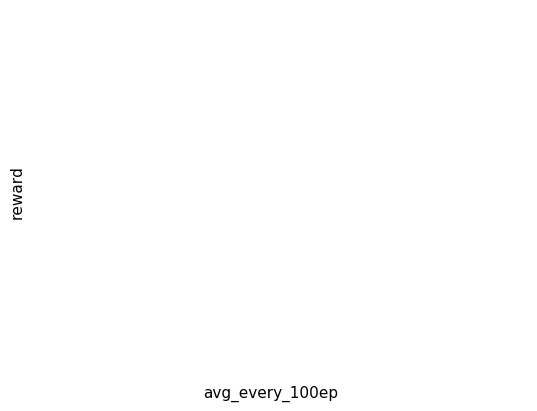

<ggplot: (-9223371948684225584)>

In [16]:
n=0
c=0
xx=[]
for i in df['Reward']:
    n+=i
    c+=1
    if c%100==0:
        xx.append(n/100)
        n=0
        
df__=pd.DataFrame({'reward':xx,'avg_every_100ep':[i for i in range(len(xx))]})

ggplot(df__, aes(x='avg_every_100ep',y='reward'))+ \
    geom_line(size=0.6,alpha=0.5) +\
    stat_smooth(colour='blue', span=0.2,linetype='dashed')+theme_minimal()

C:\Users\Boss\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


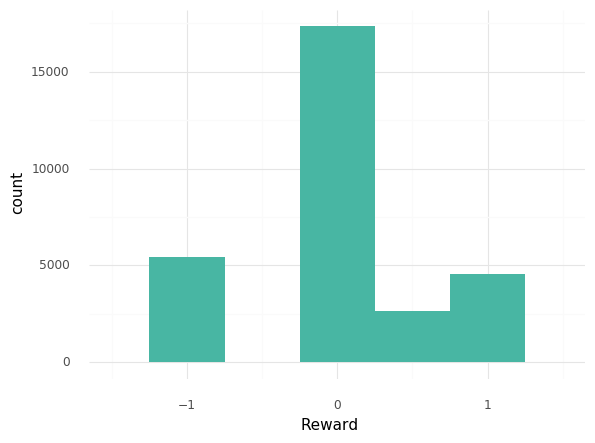

<ggplot: (-9223371892051844678)>

In [25]:
ggplot(df,aes(x='Reward'))+\
geom_histogram(binwidth=0.5,fill='#48b6a3')+\
xlim(-1.5,1.5)+theme_minimal()

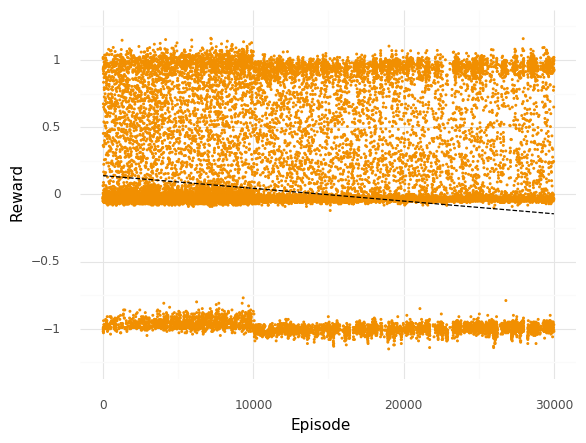

<ggplot: (-9223371892165270233)>

In [26]:
ggplot(df, aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(-1.25,1.25)+theme_minimal()

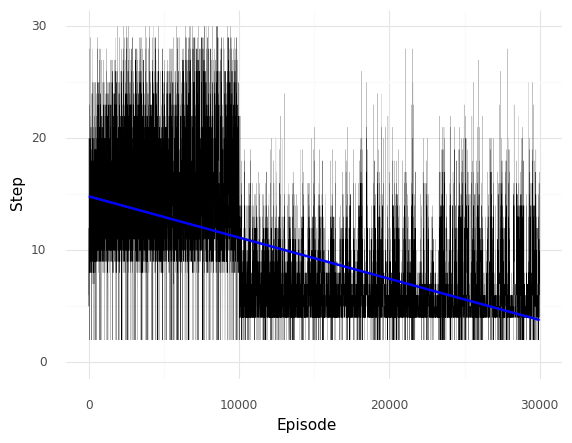

<ggplot: (144688211860)>

In [27]:
ggplot(df, aes(x='Episode',y='Step'))+ \
    geom_line(size=0.05) +\
    stat_smooth(colour='blue', span=0.2)+\
        ylim(0,30)+theme_minimal()

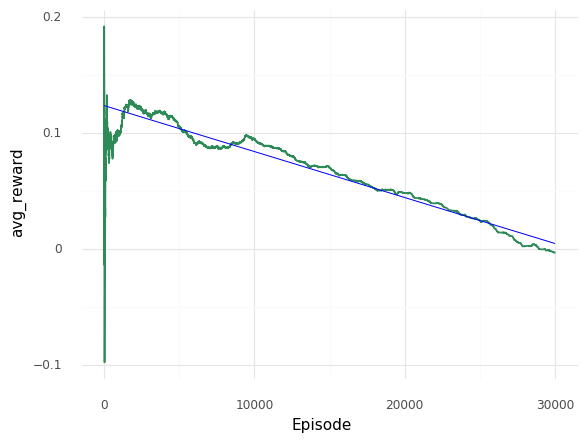

<ggplot: (144690463268)>

In [28]:
ggplot(df, aes(x='Episode',y='avg_reward'))+ \
    geom_line(size=0.7,color='seagreen') +\
    stat_smooth(colour='blue', span=0.3,size=0.4)+theme_minimal()

C:\Users\Boss\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 100 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


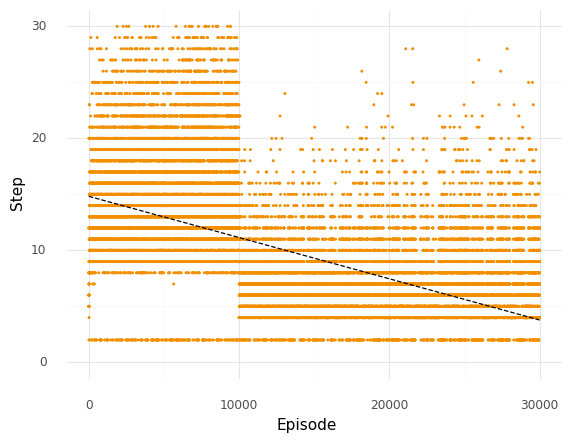

<ggplot: (144691391408)>

In [29]:
ggplot(df, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(0,30)+theme_minimal()

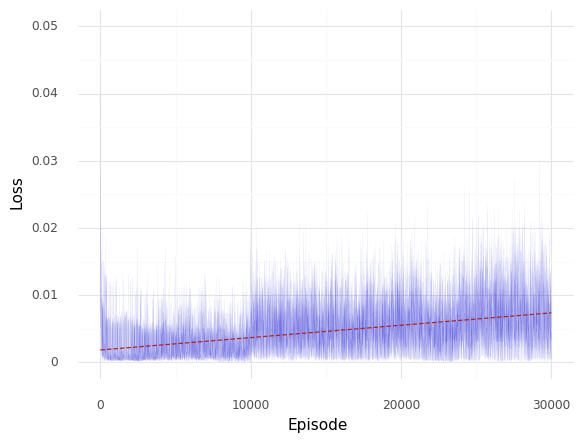

<ggplot: (-9223371892163455621)>

In [30]:
ggplot(df, aes(x='Episode',y='Loss'))+ \
  geom_line(size=0.01,color='mediumblue') +\
    geom_smooth(method="lm",color='firebrick', se=False, size=0.5, linetype="dashed")+\
ylim(0,0.05)+theme_minimal()

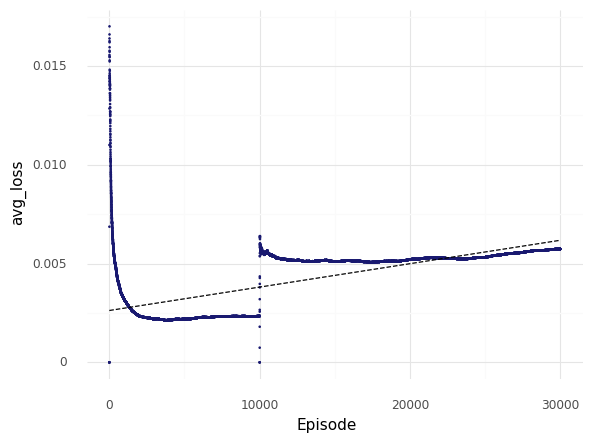

<ggplot: (144691322646)>

In [31]:
ggplot(df, aes(x='Episode',y='avg_loss'))+ \
  geom_point(color='midnightblue',size=0.05) +\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+theme_minimal()

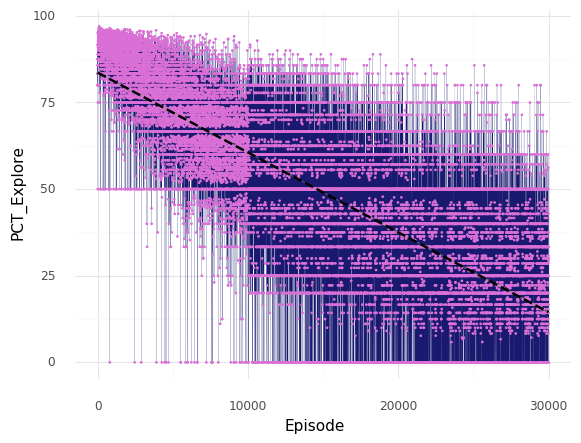

<ggplot: (-9223371892162076956)>

In [32]:
ggplot(df, aes(x='Episode',y='PCT_Explore'))+ \
  geom_line(color='midnightblue',size=0.05) +\
    geom_point(color="orchid", size=0.1)+\
    geom_smooth( size=1, linetype="dashed")+theme_minimal()

# Save data and model

In [43]:
name='full_deep_brake_cont_reward' ##INSERT FILE NAME
n = datetime.datetime.now()
n = n.strftime('_%m%d%y_%H%M')

##real
file_path="D:\\Desktop\\Full report\\Brake\\Deep brake with maximaization bias\\"
df.to_csv(file_path+'{}.csv'.format(name))
agent.save_model(file_path+name)

##backup
name=name+n
file_path_backup="D:\\Desktop\\Full report\\Brake\\Deep brake with maximaization bias\\"
df.to_csv(file_path_backup+'{}.csv'.format(name))
agent.save_model(file_path_backup+name)

NameError: name 'agent' is not defined

# Load model for Test

In [17]:
model_name='full_deep_brake_cont_reward_limit_action@50000'

json_file = open('C:\\Users\\Lee\\CARLA_0.9.8\\WindowsNoEditor\\PythonAPI\\examples\\DATA\\t\\{}.json'.format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:\\Users\\Lee\\CARLA_0.9.8\\WindowsNoEditor\\PythonAPI\\examples\\DATA\\t\\{}.h5".format(model_name))
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 15        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


# Test model 

In [18]:
if carla_is_running():
    print('carla is running')
else:
    close_carla()
    open_carla('fast')
    time.sleep(17)

test_ep = 10
test_step = []
test_reward = []
dto = []
dto_err = []
sleepy = 0.3

env = CarEnv()

state_size = loaded_model.input.shape[1]
action_size = loaded_model.output.shape[1]
print('State size = {} // Action size = {} '.format(state_size,action_size))
    
with tqdm(total=test_ep) as pbar:
    for episode in range(test_ep):
        
        state=env.reset()
        
        done = False
        step = 0
        rewards = 0
        steer_ = 0
            
        while True:
            step += 1
            state = np.array([[i for i in state]])
            action = np.argmax(loaded_model.predict(state))
            time.sleep(0.01)
            state,reward,done,_ = env.step(action)
            rewards += reward
    
            if done:
                break
                
        dto.append(state[0])   
        dto_err.append(2-state[0]) # we set 2-metre-from-the-wall length as a goal of the car to stop
        test_reward.append(rewards)
        test_step.append(step)
        pbar.update(1)
xxx()

carla is running
State size = 4 // Action size = 3 


In [19]:
df_test=pd.DataFrame({'Episode':[i for i in range(len(test_step))],\
                      'Step':test_step,'Reward':test_reward,'distance to obstacle':dto, 'distance error':dto_err})
df_test

,Episode,Step,Reward,distance to obstacle,distance error
0,0,16,0.924676,3.646712,-1.646712
1,1,14,0.995147,1.582038,0.417962
2,2,19,0.821385,4.535773,-2.535773
3,3,23,0.894708,3.946923,-1.946923
4,4,26,0.881008,4.069710,-2.069710
5,5,21,0.927094,3.620069,-1.620069
6,6,22,0.908087,3.819026,-1.819026
7,7,23,0.940266,3.466437,-1.466437
8,8,23,0.973061,2.984789,-0.984789
9,9,22,0.978826,2.873077,-0.873077


In [20]:
df_test.describe()

,Episode,Step,Reward,distance to obstacle,distance error
count,10.00000,10.00000,10.000000,10.000000,10.000000
mean,4.50000,20.90000,0.924426,3.454455,-1.454455
std,3.02765,3.60401,0.051894,0.820047,0.820047
min,0.00000,14.00000,0.821385,1.582038,-2.535773
25%,2.25000,19.50000,0.898053,3.105201,-1.914949
50%,4.50000,22.00000,0.925885,3.633390,-1.633390
75%,6.75000,23.00000,0.964862,3.914949,-1.105201
max,9.00000,26.00000,0.995147,4.535773,0.417962


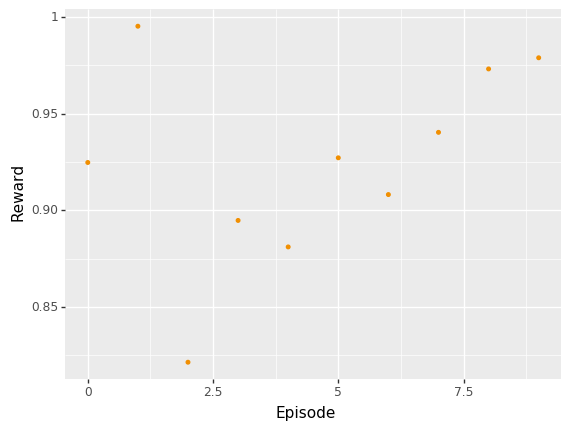

<ggplot: (-9223371948681397732)>

In [21]:
ggplot(df_test, aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=1)

In [22]:
close_carla()